### Financial Engineering 1: Hedging Assignment

In [96]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pyfinance.options import BSM

from scipy.stats import norm

In [97]:
# import data and print head to get rough idea of what is contained
data = pd.read_csv('./fe2.csv')
data.head()

,Unnamed: 0,Date,Underlying,C250,C255,C260,C265,C270,C275,C280,...,P400,P405,P410,P415,P420,P425,P430,P435,P440,P445
0,0,2023-08-21,321.88,77.91,NaN,67.65,NaN,55.00,54.39,49.6,...,77.97,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2023-08-22,322.46,77.60,NaN,69.55,NaN,NaN,54.27,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2023-08-23,327.00,NaN,NaN,73.20,NaN,NaN,59.00,54.3,...,71.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,2023-08-24,319.97,NaN,NaN,66.20,NaN,57.77,60.60,50.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,2023-08-25,322.98,NaN,73.85,64.93,62.29,NaN,NaN,50.3,...,NaN,NaN,NaN,94.03,NaN,NaN,NaN,NaN,NaN,NaN


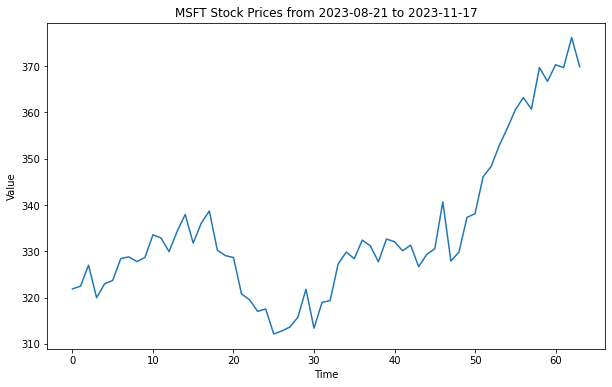

In [98]:
# display underlying stock prices in a chart
fig = plt.figure(figsize=(10,6))
plt.plot(data.index, data['Underlying'])
plt.title(f'MSFT Stock Prices from {data["Date"].min()} to {data["Date"].max()}')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

In [99]:
# Cleaning (dropping useless colums)

# Drop the "Unnamed: 0" column 
data = data.drop('Unnamed: 0', axis=1)

# Drop put options (we only consider call options here)
put_options_to_drop = [col for col in data.columns if col.startswith('P')]
data = data.drop(columns=put_options_to_drop)

data.head()

,Date,Underlying,C250,C255,C260,C265,C270,C275,C280,C285,...,C400,C405,C410,C415,C420,C425,C430,C435,C440,C445
0,2023-08-21,321.88,77.91,NaN,67.65,NaN,55.00,54.39,49.6,NaN,...,1.21,1.01,0.88,0.73,0.59,0.52,NaN,0.38,0.33,NaN
1,2023-08-22,322.46,77.60,NaN,69.55,NaN,NaN,54.27,NaN,NaN,...,1.21,1.07,0.94,NaN,0.67,0.60,0.48,NaN,NaN,NaN
2,2023-08-23,327.00,NaN,NaN,73.20,NaN,NaN,59.00,54.3,NaN,...,1.53,1.28,1.08,0.94,0.78,0.73,0.64,0.55,NaN,0.37
3,2023-08-24,319.97,NaN,NaN,66.20,NaN,57.77,60.60,50.0,44.62,...,1.15,0.97,0.91,0.71,0.68,NaN,0.48,NaN,0.33,NaN
4,2023-08-25,322.98,NaN,73.85,64.93,62.29,NaN,NaN,50.3,43.80,...,1.14,0.97,0.83,NaN,NaN,NaN,0.44,0.38,NaN,0.30


In [100]:
# Add T column (remaining days to maturity)

maturity = pd.to_datetime('2023-11-27')
data['T'] = maturity - pd.to_datetime(data['Date'])
data['T'] = data['T'].dt.days

# Add r column (interest rate) - for the moment arbitrary fixed
data['r'] = 0.05

data.head()

,Date,Underlying,C250,C255,C260,C265,C270,C275,C280,C285,...,C410,C415,C420,C425,C430,C435,C440,C445,T,r
0,2023-08-21,321.88,77.91,NaN,67.65,NaN,55.00,54.39,49.6,NaN,...,0.88,0.73,0.59,0.52,NaN,0.38,0.33,NaN,98,0.05
1,2023-08-22,322.46,77.60,NaN,69.55,NaN,NaN,54.27,NaN,NaN,...,0.94,NaN,0.67,0.60,0.48,NaN,NaN,NaN,97,0.05
2,2023-08-23,327.00,NaN,NaN,73.20,NaN,NaN,59.00,54.3,NaN,...,1.08,0.94,0.78,0.73,0.64,0.55,NaN,0.37,96,0.05
3,2023-08-24,319.97,NaN,NaN,66.20,NaN,57.77,60.60,50.0,44.62,...,0.91,0.71,0.68,NaN,0.48,NaN,0.33,NaN,95,0.05
4,2023-08-25,322.98,NaN,73.85,64.93,62.29,NaN,NaN,50.3,43.80,...,0.83,NaN,NaN,NaN,0.44,0.38,NaN,0.30,94,0.05


In [101]:
# Strike price should become a variable

# Renaming call option columns to just have a float
columns_to_transform = [col for col in data.columns if col.startswith('C')]
new_column_names = {col: float(col[1:]) for col in columns_to_transform}
data.rename(columns=new_column_names, inplace=True)

data.head()

,Date,Underlying,250.0,255.0,260.0,265.0,270.0,275.0,280.0,285.0,...,410.0,415.0,420.0,425.0,430.0,435.0,440.0,445.0,T,r
0,2023-08-21,321.88,77.91,NaN,67.65,NaN,55.00,54.39,49.6,NaN,...,0.88,0.73,0.59,0.52,NaN,0.38,0.33,NaN,98,0.05
1,2023-08-22,322.46,77.60,NaN,69.55,NaN,NaN,54.27,NaN,NaN,...,0.94,NaN,0.67,0.60,0.48,NaN,NaN,NaN,97,0.05
2,2023-08-23,327.00,NaN,NaN,73.20,NaN,NaN,59.00,54.3,NaN,...,1.08,0.94,0.78,0.73,0.64,0.55,NaN,0.37,96,0.05
3,2023-08-24,319.97,NaN,NaN,66.20,NaN,57.77,60.60,50.0,44.62,...,0.91,0.71,0.68,NaN,0.48,NaN,0.33,NaN,95,0.05
4,2023-08-25,322.98,NaN,73.85,64.93,62.29,NaN,NaN,50.3,43.80,...,0.83,NaN,NaN,NaN,0.44,0.38,NaN,0.30,94,0.05


In [102]:
# Now we can use melt function so that the strike price becomes a variable
data1 = data.melt(id_vars=['Underlying', 'Date', 'T', 'r'], var_name="E").dropna()

# We rename the Call option price to Cobs
data1.rename({'value':'Cobs'}, axis='columns', inplace=True)

print(data1)

      Underlying        Date   T     r      E   Cobs
0         321.88  2023-08-21  98  0.05  250.0  77.91
1         322.46  2023-08-22  97  0.05  250.0  77.60
10        333.55  2023-09-05  83  0.05  250.0  86.25
12        329.91  2023-09-07  81  0.05  250.0  84.95
13        334.27  2023-09-08  80  0.05  250.0  89.20
...          ...         ...  ..   ...    ...    ...
2532      332.42  2023-10-11  47  0.05  445.0   0.02
2541      330.53  2023-10-24  34  0.05  445.0   0.01
2547      346.07  2023-11-01  26  0.05  445.0   0.01
2551      360.53  2023-11-07  20  0.05  445.0   0.01
2554      369.67  2023-11-10  17  0.05  445.0   0.01

[2102 rows x 6 columns]


In [103]:
# Scaling variables
data1['r'] = data1['r'] / 100
data1['T'] = data1['T'] / 252
data1['Underlying'] = data1['Underlying'] / 1000
data1['E'] = data1['E'] / 1000
data1['Cobs'] = data1['Cobs'] / 1000

# Computing volatility for each option price 
data1['volatility'] = data1.apply(lambda row:  BSM(kind='call', S0=row['Underlying'], K=row['E'], T= row['T'], r=row['r'], sigma=0.1).implied_vol(value = row['Cobs']), axis = 1)
print(data1)

C:\Users\ayman\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pyfinance\options.py:242: RuntimeWarning: divide by zero encountered in scalar divide
  vol = vol + diff / opt.vega()
C:\Users\ayman\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pyfinance\options.py:149: RuntimeWarning: invalid value encountered in scalar divide
  self.d1 = (
C:\Users\ayman\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pyfinance\options.py:151: RuntimeWarning: overflow encountered in scalar power
  + (self.r + 0.5 * self.sigma ** 2) * self.T
C:\Users\ayman\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pyfinance\options.py:242: RuntimeWarning: overflow encountered in scalar divide
  vol = vol + diff / opt.vega(

      Underlying        Date         T       r      E     Cobs  volatility
0        0.32188  2023-08-21  0.388889  0.0005   0.25  0.07791    0.406388
1        0.32246  2023-08-22  0.384921  0.0005   0.25  0.07760    0.388630
10       0.33355  2023-09-05  0.329365  0.0005   0.25  0.08625    0.377792
12       0.32991  2023-09-07  0.321429  0.0005   0.25  0.08495    0.446568
13       0.33427  2023-09-08  0.317460  0.0005   0.25  0.08920    0.459767
...          ...         ...       ...     ...    ...      ...         ...
2532     0.33242  2023-10-11  0.186508  0.0005  0.445  0.00002         NaN
2541     0.33053  2023-10-24  0.134921  0.0005  0.445  0.00001         NaN
2547     0.34607  2023-11-01  0.103175  0.0005  0.445  0.00001         NaN
2551     0.36053  2023-11-07  0.079365  0.0005  0.445  0.00001         NaN
2554     0.36967  2023-11-10  0.067460  0.0005  0.445  0.00001         NaN

[2102 rows x 7 columns]


In [104]:
# Filtering unwanted values, i.e. volatility smaller than zero and larger than 0.6

data1 = data1[(data1['volatility'] < 0.6) & (data1['volatility'] > 0.0)]
print(data1)

      Underlying        Date         T       r      E     Cobs  volatility
0        0.32188  2023-08-21  0.388889  0.0005   0.25  0.07791    0.406388
1        0.32246  2023-08-22  0.384921  0.0005   0.25  0.07760    0.388630
10       0.33355  2023-09-05  0.329365  0.0005   0.25  0.08625    0.377792
12       0.32991  2023-09-07  0.321429  0.0005   0.25  0.08495    0.446568
13       0.33427  2023-09-08  0.317460  0.0005   0.25  0.08920    0.459767
...          ...         ...       ...     ...    ...      ...         ...
1659     0.36668  2023-11-13  0.055556  0.0005  0.375  0.00105    0.110818
1660     0.37027  2023-11-14  0.051587  0.0005  0.375  0.00147    0.097984
1661     0.36967  2023-11-15  0.047619  0.0005  0.375  0.00080    0.081888
1662     0.37617  2023-11-16  0.043651  0.0005  0.375  0.00246    0.057960
1726     0.37617  2023-11-16  0.043651  0.0005   0.38  0.00052    0.058077

[1062 rows x 7 columns]


In [105]:
# Function to calculate Delta (Nd1)
# def calculate_Nd1(row):
#     S, E, r, sigma, T = row['Underlying'], row['E'], row['r'], row['volatility'], row['T']

#     d1 = (np.log(S/E) + (r + sigma ** 2 / 2) * (T)) / (sigma * np.sqrt(T) + 1e-8)  # Adding a small epsilon to avoid division by zero
#     Nd1 = norm.cdf(d1)

#     return Nd1

# Adding new column Delta, Vega and Gamma
data1['Delta'] = data1.apply(lambda row:  BSM(kind='call', S0=row['Underlying'], K=row['E'], T= row['T'], r=row['r'], sigma=row['volatility']).delta(), axis = 1)
data1['Vega'] = data1.apply(lambda row:  BSM(kind='call', S0=row['Underlying'], K=row['E'], T= row['T'], r=row['r'], sigma=row['volatility']).vega(), axis = 1)
data1['Gamma'] = data1.apply(lambda row:  BSM(kind='call', S0=row['Underlying'], K=row['E'], T= row['T'], r=row['r'], sigma=row['volatility']).gamma(), axis = 1)

# data1['Delta'] = data1.apply(calculate_Nd1, axis=1)
print(data1)

# To have a complete picture of what is in data1
data1.to_csv('data1.csv', index=False)


      Underlying        Date         T       r      E     Cobs  volatility  \
0        0.32188  2023-08-21  0.388889  0.0005   0.25  0.07791    0.406388   
1        0.32246  2023-08-22  0.384921  0.0005   0.25  0.07760    0.388630   
10       0.33355  2023-09-05  0.329365  0.0005   0.25  0.08625    0.377792   
12       0.32991  2023-09-07  0.321429  0.0005   0.25  0.08495    0.446568   
13       0.33427  2023-09-08  0.317460  0.0005   0.25  0.08920    0.459767   
...          ...         ...       ...     ...    ...      ...         ...   
1659     0.36668  2023-11-13  0.055556  0.0005  0.375  0.00105    0.110818   
1660     0.37027  2023-11-14  0.051587  0.0005  0.375  0.00147    0.097984   
1661     0.36967  2023-11-15  0.047619  0.0005  0.375  0.00080    0.081888   
1662     0.37617  2023-11-16  0.043651  0.0005  0.375  0.00246    0.057960   
1726     0.37617  2023-11-16  0.043651  0.0005   0.38  0.00052    0.058077   

         Delta      Vega      Gamma  
0     0.869638  0.042545 

In [106]:
# Start date for hedging, 45 days before last data point in dataframe
start_date = pd.to_datetime('2023-11-27') - pd.DateOffset(45)
print(start_date)

# Find the call option price with delta value that is closest to 0.5 on the start date, to get the ATM option
filtered_rows = data1[pd.to_datetime(data1['Date']) == start_date]
atm_call = filtered_rows.loc[(filtered_rows['Delta'] - 0.5).abs().idxmin()]
option_price, strike, delta, date = atm_call['Cobs'], atm_call['E'], atm_call['Delta'], atm_call['Date']
print(f"Atm: Call option price with Start date = {date}, Delta = {delta}, Option price = {option_price}, Strike = {strike}")


2023-10-13 00:00:00
Atm: Call option price with Start date = 2023-10-13, Delta = 0.48925161034654463, Option price = 0.01109, Strike = 0.33


In [107]:
portfolio_value = atm_call['Cobs']
portfolio_delta = atm_call['Delta']
print(f'Portfolio Value: {portfolio_value}, Portfolio Delta: {portfolio_delta}')
replicating_portfolio_delta = -1*portfolio_delta
replicating_porfolio_value = replicating_portfolio_delta*data1[pd.to_datetime(pd.to_datetime(data1['Date'])) == start_date]['Underlying'].to_numpy()[0]
print(f'Current shares in replicating portfolio: 0')
print(f'Sell {portfolio_delta} shares to hedge portfolio')
print(f'Replicating Portfolio Value: {replicating_porfolio_value}, Replicating Portfolio Delta: {replicating_portfolio_delta}')
print(f'Total Portfolio Value: {portfolio_value + replicating_porfolio_value}, Total Portfolio Delta: {portfolio_delta + replicating_portfolio_delta}')

Portfolio Value: 0.01109, Portfolio Delta: 0.48925161034654463
Current shares in replicating portfolio: 0
Sell 0.48925161034654463 shares to hedge portfolio
Replicating Portfolio Value: -0.16034243025887307, Replicating Portfolio Delta: -0.48925161034654463
Total Portfolio Value: -0.14925243025887308, Total Portfolio Delta: 0.0


In [108]:
next_day = start_date + pd.DateOffset(3)
new_portfolio_value = data1[(pd.to_datetime(data1['Date']) == next_day) & (data1['E'] == atm_call['E'])]['Cobs'].to_numpy()[0]
new_portfolio_delta = data1[(pd.to_datetime(data1['Date']) == next_day) & (data1['E'] == atm_call['E'])]['Delta'].to_numpy()[0]
print(f'Portfolio Value: {new_portfolio_value}, Portfolio Delta: {new_portfolio_delta}')
new_replicating_portfolio_delta = -1*new_portfolio_delta
new_replicating_porfolio_value = new_replicating_portfolio_delta*data1[pd.to_datetime(pd.to_datetime(data1['Date'])) == next_day]['Underlying'].to_numpy()[0]
print(f'Current shares in replicating portfolio: {portfolio_value}')
print(f'Sell {new_portfolio_delta - portfolio_value} shares to hedge portfolio')
print(f'Replicating Portfolio Value: {new_replicating_porfolio_value}, Replicating Portfolio Delta: {new_replicating_portfolio_delta}')
print(f'Total Portfolio Value: {new_portfolio_value + new_replicating_porfolio_value}, Total Portfolio Delta: {new_portfolio_delta + new_replicating_portfolio_delta}')

Portfolio Value: 0.013349999999999999, Portfolio Delta: 0.5533673521489916
Current shares in replicating portfolio: 0.01109
Sell 0.5422773521489915 shares to hedge portfolio
Replicating Portfolio Value: -0.18407211601884055, Replicating Portfolio Delta: -0.5533673521489916
Total Portfolio Value: -0.17072211601884055, Total Portfolio Delta: 0.0


In [109]:
def get_option_portfolio_values(portfolio, start_date, end_date, data):
    portfolio_values = []

    for index, row in data[(data['Date'] >= start_date) & (data['Date'] <= end_date)].iterrows():
        value = 0
        for strike, quantity, buy_sell in portfolio:
            row_strike = row['E']
            row_price= row['Cobs']
            if (row_strike == strike and np.isnan(option_price)):
                raise ValueError('portfolio contains nan price')
            elif buy_sell == 'buy':
                value += row_price * quantity
            else:
                value -= row_price * quantity
        portfolio_values.append(value)

    return np.array(portfolio_values)

def get_values(ticker, start_date, end_date, data):
    return data[(data['Date'] >= start_date) & (data['Date'] <= end_date)][ticker].to_numpy()

def get_delta_values(portfolio, start_date, end_date, data):
    # delta values must be added to data frame first
    delta_values = []

    for index, row in data[(data['Date'] >= start_date) & (data['Date'] <= end_date)].iterrows():
        value = 0
        for strike, quantity, buy_sell in portfolio:
            row_strike = row['E']
            row_delta = row['Delta']
            if (row_strike == strike and np.isnan(row_delta)):
                raise ValueError('portfolio contains nan delta value')
            elif buy_sell == 'buy':
                value += row_delta * quantity
            else:
                value -= row_delta * quantity
        delta_values.append(value)

    return np.array(delta_values)

def get_vega_values(portfolio, start_date, end_date, data):
    # vega values must be added to data frame first
    vega_values = []

    for index, row in data[(data['Date'] >= start_date) & (data['Date'] <= end_date)].iterrows():
        value = 0
        for strike, quantity, buy_sell in portfolio:
            row_strike = row['E']
            row_vega = row['Vega']
            if (row_strike == strike and np.isnan(row_vega)):
                raise ValueError('portfolio contains nan vega value')
            elif buy_sell == 'buy':
                value += row_vega * quantity
            else:
                value -= row_vega * quantity
        vega_values.append(value)

    return np.array(vega_values)

def delta_hedge(hedging_frequency, portfolio_values, underlying_values, delta_values):
    if (any(np.isnan(delta_values)) or any(np.isnan(portfolio_values)) or any(np.isnan(underlying_values)) 
            or hedging_frequency <= 0 or hedging_frequency >= len(delta_values)):
        return False
    
    portfolio_value = portfolio_values[0]
    underlying_value = underlying_values[0]
    delta = delta_values[0]
    accuracies = []

    for i in range(hedging_frequency, len(delta_values), hedging_frequency):
        accuracy = (portfolio_values[i] - portfolio_value) - (underlying_values[i] - underlying_value) * delta
        accuracies.append(accuracy)
        portfolio_value = portfolio_values[i]
        underlying_value = underlying_values[i]
        delta = delta_values[i]

    mean_squared_error = sum([num**2 for num in accuracies]) / len(accuracies)

    return {
        'accuracies': accuracies,
        'mean_squered_error': mean_squared_error
    }

def option_portfolio_delta_hedging(portfolio, start_date, end_date, hedging_frequency, data):
    # portfolio example: [['C250', 2, 'buy'], ['P400', 1, 'sell']]

    portfolio_values = get_option_portfolio_values(portfolio, start_date, end_date, data)
    underlying_values = get_values('Underlying', start_date, end_date, data)
    delta_values = get_delta_values(portfolio, start_date, end_date, data)

    hedging_results = delta_hedge(hedging_frequency, portfolio_values, underlying_values, delta_values)
    return hedging_results

def solve_2_by_2_linear_system(equation_one, equation_two):
    # equations of the form ax + by = c, dx + ey = f
    a, b, c = equation_one
    d, e, f = equation_two

    x = (b * f - e * c) / (b * d - a * e)
    y = (c - a * x) / b

    return (x, y)

def delta_vega_hedge(hedging_frequency, portfolio_values, portfolio_delta_values, portfolio_vega_values, sec_one_values, sec_one_delta_values, 
                        sec_one_vega_values, sec_two_values, sec_two_delta_values, sec_two_vega_values):

    portfolio_value = portfolio_values[0]
    portfolio_delta= portfolio_delta_values[0]
    portfolio_vega = portfolio_vega_values[0]
    sec_one = sec_one_values[0]
    sec_one_delta = sec_one_delta_values[0]
    sec_one_vega = sec_one_vega_values[0]
    sec_two = sec_two_values[0]
    sec_two_delta = sec_two_delta_values[0]
    sec_two_vega = sec_two_vega_values[0]
    sec_one_amount, sec_two_amount = solve_2_by_2_linear_system([sec_one_delta, sec_two_delta, -portfolio_delta], 
                                                                    [sec_one_vega, sec_two_vega, -portfolio_vega])
    accuracies = []

    for i in range(hedging_frequency, len(sec_two_delta_values), hedging_frequency):
        change_in_portfolio = portfolio_values[i] - portfolio_value
        change_in_replication = sec_one_amount * (sec_one_values[i] - sec_one) + sec_two_amount * (sec_two_values[i] - sec_two)
        accuracy = change_in_portfolio - change_in_replication
        accuracies.append(accuracy)
        portfolio_value = portfolio_values[i]
        portfolio_delta= portfolio_delta_values[i]
        portfolio_vega = portfolio_vega_values[i]
        sec_one = sec_one_values[i]
        sec_one_delta = sec_one_delta_values[i]
        sec_one_vega = sec_one_vega_values[i]
        sec_two = sec_two_values[i]
        sec_two_delta = sec_two_delta_values[i]
        sec_two_vega = sec_two_vega_values[i]
        sec_one_amount, sec_two_amount = solve_2_by_2_linear_system([sec_one_delta, sec_two_delta, -portfolio_delta], 
                                                                        [sec_one_vega, sec_two_vega, -portfolio_vega])

    mean_squared_error = sum([num**2 for num in accuracies]) / len(accuracies)

    return {
        'accuracies': accuracies,
        'mean_squered_error': mean_squared_error
    }

def option_portfolio_delta_vega_hedging(portfolio, security_one, security_two, start_date, end_date, hedging_frequency, data):
    # portfolio example: [['C250', 2, 'buy'], ['P400', 1, 'sell']]

    portfolio_values = get_option_portfolio_values(portfolio, start_date, end_date, data)
    portfolio_delta_values = get_delta_values(portfolio, start_date, end_date, data)
    portfolio_vega_values = get_vega_values(portfolio, start_date, end_date, data)
    sec_one_values = get_values(security_one, start_date, end_date, data)
    sec_one_delta_values = get_delta_values([[security_one, 1, 'buy']], start_date, end_date, data)
    sec_one_vega_values = get_vega_values([[security_one, 1, 'buy']], start_date, end_date, data)
    sec_two_values = get_values(security_two, start_date, end_date, data)
    sec_two_delta_values = get_delta_values([[security_two, 1, 'buy']], start_date, end_date, data)
    sec_two_vega_values = get_vega_values([[security_two, 1, 'buy']], start_date, end_date, data)
    
    hedging_results = delta_vega_hedge(hedging_frequency, portfolio_values, portfolio_delta_values, portfolio_vega_values, sec_one_values, 
                                            sec_one_delta_values, sec_one_vega_values, sec_two_values, sec_two_delta_values, sec_two_vega_values)
    return hedging_results

In [110]:
results = option_portfolio_delta_hedging([[300, 1, 'buy']], '2023-10-18', '2023-11-17', 1, data1)
print(results)

{'accuracies': [-0.00011370254254843113, 5.2081575912070466e-05, -0.0004265937679573395, 1.654617339660533e-05, -0.00027368348095910267, -0.0034821232224321575, 4.995236866942401e-05, 0.0005838652569438579, -0.0033718552445989175, 0.0004422319752789179, 0.0009417687906900299, -0.005516071275204107, 0.0019709149689356507, -0.0007633454220396397, 0.0012526990704159703, -0.00012279461133531816, -2.666728834396911e-05, -0.003576608980663247, 0.0015203476271264688, -0.0020193342641107457, -0.0014348784322743243, 0.004286468484041358, -0.0021117933541298373, 0.0002381334336603487, -0.0011915976208655603, -0.0021312460868426327, 0.0014159764318122953, -0.0010674973037807806, -0.0006472338135468953, 0.0031672834803762534, -0.0015806082267028135, -0.002621159840403479, 0.0011369950792227033, -0.001920533691649854, -0.00041969650872426866, 6.973919144042978e-05, 0.0005664122463019759, -0.002000343980445046, 0.0005936730564013388, -0.000617893591984842, 0.0007141307837962921, 0.001098114078211223

In [111]:
# data.tail()[['Underlying', 'd_C370_dS', 'd_C365_dS', 'd_C320_dS']]